# Partie II : Génération de texte avec des modèles “RNN”
Dans cette deuxième partie, nous allons entraîner et valider un modèle de type RNN pour la génération de texte, tout en identifiant d’éventuelles limites (étudiées théoriquement pendant le cours).

In [1]:
#### Importation des bibliothèques
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import matplotlib.pyplot as plt


#### 1. Afin de procéder à notre génération de texte nous allons tout d'abord trouver un texte orignal sur l'Afrique ecri par nous-mêmes et qui servira de données d’entrainement de notre modèle de génération de texte

In [2]:
corpus = """
Quand la haine devient plus forte que l’inspiration
On trébuche sur le texte et on en a marre des ponctuations
Et il y a cette petite voix dans ma tête qui me dit : arrête !
Quand même les mots se vexent si c’est pour parler de ces concepts
Et que l’humain lui-même se déshumanise
Face aux ambitions politiques et aux aspects capitalistes

J’ai deux, trois mots pour ce monde déchiré
Qui, obsédé par le pouvoir, en oublie sa dignité
J’attends toujours ce changement dans ce faux discours
Qui, avant d’être exécuté, avait déjà fait demi-tour
Y’a des personnes qui tendent la main, y’a des pays qui le font aussi
Je vais pas rentrer dans les détails, l’histoire est bien pourrie
Depuis toujours, de l’injustice à répétition
Moi, j’ai vu des enfants mourir de malnutrition
L’Afrique a besoin de fonds pour gérer le matériel
Et se passer des dons, sa dépendance actuelle
Quel gâchis d’avoir une terre fertile mais pas d’argent pour acheter les graines
Et à force, on nous apprend à cultiver de la haine
Alors égalisons le monde à la façon Robin des Bois
Je volerai des mots aux esclaves pour les transmettre aux rois

Mais en attendant, je me bats contre le monde pour ce complexe
Qu’on veut me faire porter, forcer le racisme avec
Que je devrais avoir honte de mes origines, enfant africain, ça fait de la peine
De vos cheveux, vos visages à votre couleur
D’ébène
Mais j’ai plus que des défauts si vous me regardez bien
Vous aimeriez ma peau et, au fait, je n’ai honte de rien
Alors arrêtez de créer de la différence entre les hommes
On a tous en commun l’histoire d’Adam, d’Ève et la pomme
Ce sont nos égos qui fortifient l’injustice
Si on la laisse s’accroître, que dirions-nous à nos fils ?
Qu’ils devront être guerriers dans ce monde que nous-mêmes on a détruit
Qu’on n’a pas respecté ces mots que nous-mêmes on a écrits
Comment oublier ces guerres et repartir à zéro ?
Comment ferions-nous pour sourire sans que ça sonne faux ?
Faudrait qu’on apprenne à accepter nos différences
Qu’une couleur, une croyance n’est pas une référence
Qu’on réalise qu’il y a des choses plus importantes que le pouvoir
Et qu’on n’a même pas besoin de lunettes pour y voir

"""

Nous allons maintenant passer au prétraitement de notre corpus en faisant la tokenisation puis en calculant la fréquence des mots, ensuite on va trier les mots dans l'ordre de fréquence plus elevé. Ceci nous aidera à savoir quels sont les mots les plus frequents et c'est dans cet ordre qu'on va vectoriser nos mots a l'aide de leurs indexes dans la liste créée

In [3]:
#### On va tokeniser notre corpus
words = corpus.split()

In [4]:
#### On va compter la frequence de chaque mot pour en voir les mots les plus repetés
word_counts = Counter(words)

In [6]:
#### On va refaire notre vocabulaire en triant pas ordre de frequence des mots
# Création du vocabulaire trié
vocab = sorted(word_counts, key=word_counts.get, reverse=True)

# Convertir en dictionnaire {mot: index}
vocab = {word: idx for idx, word in enumerate(vocab)}

# ✅ Ajouter un token "<unk>" pour les mots inconnus
if "<unk>" not in vocab:
    vocab["<unk>"] = len(vocab)  # Ajoute "<unk>" avec un nouvel index

# Créer l'index inverse {index: mot}
index_to_word = {idx: word for word, idx in vocab.items()}

In [7]:
# Associer un index à chaque mot
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

In [8]:
# Convertir le texte en liste d'indices
indexed_text = [word_to_index[word] for word in words]

In [9]:
#### Creation de notre dataset avec une classe qui prend en heritage notre indexed_text qui contient nos mots indexé et trié dans un ordre et on calcule la longueur
#### de la liste puis on retourne un tensor avec nos x et le y a la fin
import torch.nn.functional as F

class TextDataset(Dataset):
    def __init__(self, indexed_text, sequence_length):
        self.indexed_text = indexed_text
        self.sequence_length = sequence_length

    def __len__(self):
        return max(0, len(self.indexed_text) - self.sequence_length)

    def __getitem__(self, index):
        X = torch.tensor(self.indexed_text[index:index + self.sequence_length])
        y = torch.tensor(self.indexed_text[index + 1: index + self.sequence_length + 1])

        # Appliquer le padding si la séquence est plus courte que `sequence_length`
        if len(X) < self.sequence_length:
            padding_length = self.sequence_length - len(X)
            X = F.pad(X, (0, padding_length), value=0)
            y = F.pad(y, (0, padding_length), value=0)

        return X, y


On va maintenant définir la longueur de nos séquences et définir notre dataset.
Pour le dataset on va diviser nos données en données d'entraînement, de test et de validation afin de pouvoir évaluer la performance de nos modèles.

In [10]:
sequence_length=15
dataset = TextDataset(indexed_text, sequence_length)

total_size = len(dataset)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
batch_size=32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 295, Validation: 36, Test: 38


Maintenant on a fini nos prétraitements on peut maintenant passer à la prochaine étape nos données se trouvent dans train_loader, val_loader et test_loader.

#### 2. On va mettre en place à l’aide de la bibliothèque Python PyTorch, un modèle LSTM qui sera entrainé sur les données précédemment préparées

In [12]:
class LSTMTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden


In [13]:
#### On va definir nos hyperparamètres
vocab_size = len(vocab)
embed_size = 128
hidden_size = 128
num_layers = 1
num_epochs = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


In [14]:
model_lstm = LSTMTextGenerator(vocab_size, embed_size, hidden_size, num_layers)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)

#### 3. On va mettre en place à l’aide de la bibliothèque Python PyTorch, un modèle BiLSTM qui sera entrainé sur les données précédemment préparées

In [15]:
class BiLSTMTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(BiLSTMTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.bilstm(x, hidden)
        out = self.fc(out)
        return out, hidden


In [16]:
model_bilstm = BiLSTMTextGenerator(vocab_size, embed_size, hidden_size, num_layers)
optimizer_bilstm = optim.Adam(model_bilstm.parameters(), lr=learning_rate)

#### 4. On va passer maintenant à l'entraînement de nos modèles précedemment construit

Pour que ça paraisse le plus fluide possible on va traiter par fonctions.
De ce fait, on va définir notre fonction train qui va prendre tout ce qui est nécessaire en paramètres et va nous faire l'entrainement directement.

In [17]:
def train(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs, vocab_size, device="cpu" ):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Réinitialiser hidden à chaque batch
            hidden = None

            # Forward pass
            output, hidden = model(X_batch, hidden)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        # Calcul de la perte moyenne sur l'ensemble d'entraînement
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Évaluation sur les données de validation
        avg_val_loss = evaluate(model, criterion, val_loader, vocab_size, device)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Test final après l'entraînement
    test_loss = evaluate(model, criterion, test_loader, vocab_size, device)
    print(f"Final Test Loss: {test_loss:.4f}")
    return train_losses, val_losses

def evaluate(model, criterion, dataloader, vocab_size, device="cpu"):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Réinitialiser hidden à chaque batch
            hidden = None

            # Forward pass
            output, hidden = model(X_batch, hidden)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

Entraînement sur le corpus avec le modèle Lstm

In [18]:
train_losses_lstm, val_losses_lstm = train(model_lstm, criterion, optimizer_lstm, train_loader, val_loader, test_loader, num_epochs, vocab_size, device="cpu")

Epoch [1/20] - Train Loss: 5.3915 | Val Loss: 5.2702
Epoch [2/20] - Train Loss: 5.1548 | Val Loss: 5.0419
Epoch [3/20] - Train Loss: 4.8372 | Val Loss: 4.6686
Epoch [4/20] - Train Loss: 4.3476 | Val Loss: 4.1468
Epoch [5/20] - Train Loss: 3.7316 | Val Loss: 3.5525
Epoch [6/20] - Train Loss: 3.1036 | Val Loss: 2.9361
Epoch [7/20] - Train Loss: 2.4505 | Val Loss: 2.3306
Epoch [8/20] - Train Loss: 1.9234 | Val Loss: 1.8066
Epoch [9/20] - Train Loss: 1.4789 | Val Loss: 1.3758
Epoch [10/20] - Train Loss: 1.1320 | Val Loss: 1.0635
Epoch [11/20] - Train Loss: 0.8877 | Val Loss: 0.8457
Epoch [12/20] - Train Loss: 0.7163 | Val Loss: 0.6972
Epoch [13/20] - Train Loss: 0.5952 | Val Loss: 0.5902
Epoch [14/20] - Train Loss: 0.5057 | Val Loss: 0.5153
Epoch [15/20] - Train Loss: 0.4379 | Val Loss: 0.4566
Epoch [16/20] - Train Loss: 0.3874 | Val Loss: 0.4097
Epoch [17/20] - Train Loss: 0.3477 | Val Loss: 0.3775
Epoch [18/20] - Train Loss: 0.3159 | Val Loss: 0.3522
Epoch [19/20] - Train Loss: 0.2882 | 

Entraînement sur le corpus avec le modele biLstm

In [19]:
train_losses_bilstm, val_losses_bilstm = train(model_bilstm, criterion, optimizer_bilstm, train_loader, val_loader, test_loader, num_epochs, vocab_size, device="cpu")

Epoch [1/20] - Train Loss: 5.3223 | Val Loss: 5.1186
Epoch [2/20] - Train Loss: 4.8945 | Val Loss: 4.6345
Epoch [3/20] - Train Loss: 4.2456 | Val Loss: 3.8624
Epoch [4/20] - Train Loss: 3.3406 | Val Loss: 2.9288
Epoch [5/20] - Train Loss: 2.3551 | Val Loss: 1.9505
Epoch [6/20] - Train Loss: 1.4662 | Val Loss: 1.1712
Epoch [7/20] - Train Loss: 0.8301 | Val Loss: 0.6620
Epoch [8/20] - Train Loss: 0.4825 | Val Loss: 0.4093
Epoch [9/20] - Train Loss: 0.3127 | Val Loss: 0.2839
Epoch [10/20] - Train Loss: 0.2204 | Val Loss: 0.2123
Epoch [11/20] - Train Loss: 0.1667 | Val Loss: 0.1726
Epoch [12/20] - Train Loss: 0.1341 | Val Loss: 0.1466
Epoch [13/20] - Train Loss: 0.1105 | Val Loss: 0.1286
Epoch [14/20] - Train Loss: 0.0940 | Val Loss: 0.1145
Epoch [15/20] - Train Loss: 0.0813 | Val Loss: 0.1029
Epoch [16/20] - Train Loss: 0.0718 | Val Loss: 0.0938
Epoch [17/20] - Train Loss: 0.0635 | Val Loss: 0.0863
Epoch [18/20] - Train Loss: 0.0592 | Val Loss: 0.0795
Epoch [19/20] - Train Loss: 0.0501 | 

Afin de pouvoir visualiser plus clairement la différence entre les pertes dans dans les données d'entrainement et les pertes dans les données de validation on va mettre en place un graphique capable d'illustrer tout ça

In [20]:
def plot_loss(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Train Loss for '+ model_name)
    plt.plot(val_losses, label='Validation Loss for '+ model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for '+ model_name)
    plt.legend()
    plt.show()

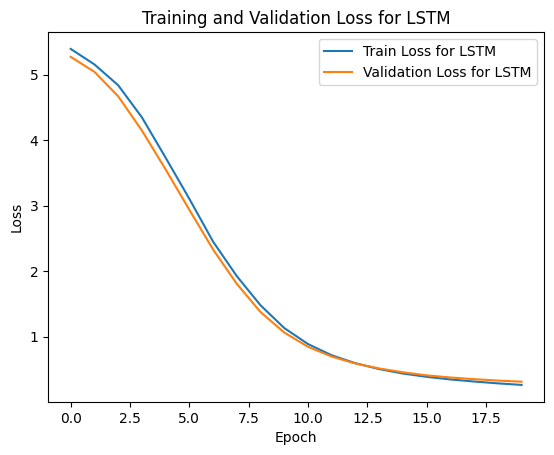

In [21]:
plot_loss(train_losses_lstm, val_losses_lstm, 'LSTM')

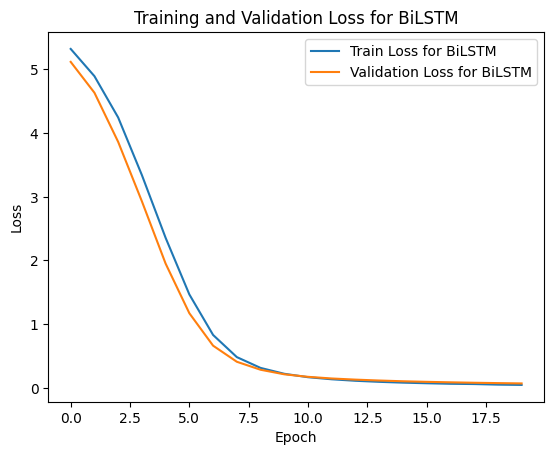

In [22]:
plot_loss(train_losses_bilstm, val_losses_bilstm, 'BiLSTM')

#### 5. On va maintenant utiliser nos modèles entrainés pour générer la suite de trois diﬀérentes phrases (pour chaque modèle) qu'on va initier avec seulement deux ou trois mots.

Pour ce faire nous allons maintenant définir une fonction de génération de texte qui va prendre en paramètres nos débuts de phrases et la longueur des phrases qu'on souhaite avoir puis va nous générer la suite par rapport aux mots inités.

In [23]:
def generate_text(model, start_text, length=50, sequence_length=10):

    model.eval()
    generated_texts = []

    for start in start_text:
        text = start.split()
        hidden = None

        with torch.no_grad():
            for _ in range(length):
                input_tensor = torch.tensor([[word_to_index.get(word, word_to_index["<unk>"]) for word in text[-sequence_length:]]])
                output, hidden = model(input_tensor, hidden)

                predicted_index = torch.argmax(output[0, -1, :]).item()
                predicted_word = index_to_word[predicted_index]
                text.append(predicted_word)

        # Ajouter le texte généré à la liste
        generated_texts.append(" ".join(text))

    return generated_texts

Nous allons maintenant appeler cette fonction de génération sur le modèle lstm puis sur le modèle bilstm en donnant à chaque fois nos trois debuts de phrases pour effectuer la génération.

In [24]:
generated_text_lstm = generate_text(model_lstm, ["Le pouvoir", "L'afrique est", "Depuis toujours"], length=50)
generated_text_lstm

['Le pouvoir Et se passer des dons, sa dépendance actuelle Quel gâchis d’avoir une terre fertile mais pas d’argent pour acheter les graines Et à force, on nous apprend à cultiver de la haine Alors égalisons le monde à la façon Robin des Bois Je volerai des mots aux esclaves pour les',
 "L'afrique est bien pourrie Depuis toujours, de l’injustice à répétition Moi, j’ai vu des enfants mourir de malnutrition L’Afrique a besoin de fonds pour gérer le matériel Et se passer des dons, sa dépendance actuelle Quel gâchis d’avoir une terre fertile mais pas d’argent pour acheter les graines Et à force, on",
 'Depuis toujours ce faux discours Qui, avant d’être exécuté, avait déjà fait demi-tour Y’a des personnes qui tendent la main, y’a des pays qui le font aussi Je vais pas rentrer dans les détails, l’histoire est bien pourrie Depuis toujours, de l’injustice à répétition Moi, j’ai vu des enfants mourir de malnutrition']

In [25]:
generated_text_bilstm = generate_text(model_bilstm, ["Le pouvoir", "L'afrique est", "Depuis toujours"], length=50)
generated_text_bilstm

['Le pouvoir Et que l’humain lui-même se déshumanise Face aux ambitions politiques et aux aspects capitalistes J’ai deux, trois mots aux ambitions politiques et aux aspects capitalistes J’ai deux, trois mots aux ambitions politiques et aux aspects capitalistes J’ai deux, trois mots aux ambitions politiques et aux aspects capitalistes J’ai deux, trois',
 "L'afrique est bien pourrie Depuis toujours, de l’injustice à répétition Moi, j’ai vu des enfants mourir de malnutrition L’Afrique à répétition Moi, j’ai vu des enfants mourir de malnutrition L’Afrique à répétition Moi, j’ai vu des enfants mourir de malnutrition L’Afrique à répétition Moi, j’ai vu des enfants mourir de malnutrition L’Afrique",
 'Depuis toujours ce monde déchiré Qui, obsédé par le pouvoir, en oublie sa dignité J’attends toujours ce monde déchiré Qui, obsédé par le pouvoir, en oublie sa dignité J’attends toujours ce monde déchiré Qui, obsédé par le pouvoir, en oublie sa dignité J’attends toujours ce monde déchiré Qui, obs

#### 6. Sur la base de ces résultats d’entrainement et d’inférence nous remarquons que le modèle Bilstm a plus de performance que le modèle Lstm car par rapport aux résultats d'entrainements on voit les pertes flagrantes du modèle lstm par rapport au modèle bisltm et avec l'inférence également. Cette situation pouvait être prévisible car en théorie le modèle bilstm est connu pour avoir plus de performance que le modèle lstm car il effectue un lstm double et parcourt le texte deux fois dans les deux sens donc c'est le modele bilstm qui l'emporte.

#### 7. Selon nous, les limites de la solution mise en place en terme de qualité des données, des modèles et de l'architecture choisie :
- **Qualité des données** :
Le corpus présente des limites comme l'absence de ponctuation et des phrases longues, ce qui peut nuire à la qualité du texte généré. Une meilleure structuration des données aurait amélioré les résultats.
- **Modèle (LSTM/GRU vs BiLSTM/BiGRU vs Alternatives)** :
LSTM : Efficace, mais lourd et nécessite de nombreux paramètres.
GRU : Plus léger que l'LSTM, avec des performances similaires, mais plus rapide.
BiLSTM/BiGRU : Améliore la compréhension du contexte en traversant la séquence dans les deux sens, mais consomme plus de ressources.
Alternatives : Des modèles comme Transformers (BERT, GPT) peuvent offrir de meilleures performances, surtout pour des tâches complexes.
- **Architecture choisie** :
L'architecture avec 128 neurones et 2 couches est adaptée au corpus actuel, mais pour des données plus complexes, il faudrait peut-être plus de couches et de neurones.
CrossEntropyLoss est bien adaptée pour la classification multiclasses, mais d'autres fonctions de perte comme CTC Loss pourraient être explorées pour des tâches séquentielles.
- **Ressources et calcul** :
Les modèles BiLSTM et BiGRU augmentent les besoins en ressources, ce qui peut ralentir l'entraînement et poser problème avec des jeux de données volumineux. Des architectures plus légères ou des modèles comme les Transformers pourraient être plus efficaces.

#### 8. Une solution alternative à la majeure partie de ces limitations
Une solution alternative pour surmonter la majeure partie de ces limitations des modèles LSTM, GRU, BiLSTM et BiGRU est l’utilisation des Transformers.

Les modèles Transformers comme BERT ou GPT sont plus efficaces pour traiter des séquences de texte complexes. Contrairement aux RNN (LSTM/GRU), les Transformers utilisent des mécanismes d'attention qui leur permettent de traiter des relations à long terme sans dépendre de la structure séquentielle, ce qui améliore considérablement la vitesse d'entraînement et la qualité des résultats, tout en étant plus performants sur des jeux de données volumineux.

Les Transformers sont aussi parallélisables, ce qui accélère l'entraînement par rapport aux RNN qui doivent traiter les données de manière séquentielle. Ils peuvent également traiter plus efficacement des contextes longs et capturer des dépendances globales dans les données.

# Partie III: Synthèse de texte à l’aide d’unauto-encoder“RNN”

Nous allons utiliser un **auto-encodeur** pour la synthèse de texte. Plus précisément, nous allons appliquer cet auto-encodeur sur un modèle **BiLSTM**. Pour ce faire, nous commencerons par diviser notre corpus en **données d'entraînement** et **données de test**. Cette approche nous permettra d'exploiter la capacité du modèle à encoder et décoder des séquences de texte de manière plus efficace, tout en améliorant la qualité de la synthèse.

In [26]:
#### Separation de notre corpus
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [27]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, bidirectional=True):
        super(LSTMAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Encoder bidirectionnel
        self.encoder_lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Decoder unidirectionnel
        self.decoder_lstm = nn.LSTM(
            hidden_size * (2 if bidirectional else 1),
            hidden_size,
            num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        encoder_out, (h, c) = self.encoder_lstm(embedded)

        if self.encoder_lstm.bidirectional:
            # Réorganisation des états cachés (couches × directions → couches × batch × hidden_size)
            h = h.view(self.encoder_lstm.num_layers, 2, -1, self.encoder_lstm.hidden_size)
            h = h.mean(dim=1)

            c = c.view(self.encoder_lstm.num_layers, 2, -1, self.encoder_lstm.hidden_size)
            c = c.mean(dim=1)

        decoder_out, _ = self.decoder_lstm(encoder_out, (h, c))
        output = self.fc(decoder_out)

        return output.permute(0, 2, 1)


In [29]:
embed_size = 256
hidden_size = 256
num_layers = 2
num_epochs = 50
learning_rate = 0.002
bidirectional = True

In [30]:
model = LSTMAutoencoder(vocab_size, embed_size, hidden_size, num_layers, bidirectional)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)

        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/50], Train Loss: 4.7107
Epoch [2/50], Train Loss: 2.7982
Epoch [3/50], Train Loss: 1.0874
Epoch [4/50], Train Loss: 0.3710
Epoch [5/50], Train Loss: 0.1412
Epoch [6/50], Train Loss: 0.0570
Epoch [7/50], Train Loss: 0.0270
Epoch [8/50], Train Loss: 0.0162
Epoch [9/50], Train Loss: 0.0117
Epoch [10/50], Train Loss: 0.0089
Epoch [11/50], Train Loss: 0.0071
Epoch [12/50], Train Loss: 0.0058
Epoch [13/50], Train Loss: 0.0048
Epoch [14/50], Train Loss: 0.0041
Epoch [15/50], Train Loss: 0.0035
Epoch [16/50], Train Loss: 0.0030
Epoch [17/50], Train Loss: 0.0026
Epoch [18/50], Train Loss: 0.0023
Epoch [19/50], Train Loss: 0.0020
Epoch [20/50], Train Loss: 0.0017
Epoch [21/50], Train Loss: 0.0015
Epoch [22/50], Train Loss: 0.0014
Epoch [23/50], Train Loss: 0.0012
Epoch [24/50], Train Loss: 0.0011
Epoch [25/50], Train Loss: 0.0010
Epoch [26/50], Train Loss: 0.0009
Epoch [27/50], Train Loss: 0.0008
Epoch [28/50], Train Loss: 0.0007
Epoch [29/50], Train Loss: 0.0007
Epoch [30/50], Train Lo

In [32]:
model.eval()
test_loss = 0
with torch.no_grad():
    for X, y in test_loader:
        output = model(X)
        loss = criterion(output, y)
        test_loss += loss.item()

print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")


Test Loss: 0.1325


In [35]:
def summarize_corpus(model, corpus_text):
    """ Résume l'ensemble du corpus en une seule fois """
    model.eval()
    with torch.no_grad():
        indexed_corpus = [word_to_index.get(word, word_to_index["<unk>"]) for word in corpus_text.split()]
        input_tensor = torch.tensor(indexed_corpus).unsqueeze(0)  # Ajouter batch dimension
        output_tensor = model(input_tensor)
        output_indices = torch.argmax(output_tensor, dim=1).squeeze().tolist()
        summarized_corpus = " ".join(index_to_word[idx] for idx in output_indices)
        return summarized_corpus

# Reconstruction du texte global à partir de test_loader
test_corpus = []
for test_X, _ in test_loader:
    for i in range(test_X.size(0)):
        sentence = " ".join(index_to_word[idx.item()] for idx in test_X[i])
        test_corpus.append(sentence)

global_test_text = " ".join(test_corpus)

global_summary = summarize_corpus(model, global_test_text)

print("=" * 80)
print("\033[1m📜 TEXTE ORIGINAL (Données de test) 📜\033[0m")
print("=" * 80)
print("\n".join(test_corpus[:10]))
print("...\n")
print("=" * 80)
print("\033[1m✍️  RÉSUMÉ GÉNÉRÉ  ✍️\033[0m")
print("=" * 80)
print(global_summary)
print("=" * 80)


📜 TEXTE ORIGINAL (Données de test) 📜
Je vais pas rentrer dans les détails, l’histoire est bien pourrie Depuis toujours, de l’injustice
des dons, sa dépendance actuelle Quel gâchis d’avoir une terre fertile mais pas d’argent pour
acheter les graines Et à force, on nous apprend à cultiver de la haine Alors
politiques et aux aspects capitalistes J’ai deux, trois mots pour ce monde déchiré Qui, obsédé
respecté ces mots que nous-mêmes on a écrits Comment oublier ces guerres et repartir à
le matériel Et se passer des dons, sa dépendance actuelle Quel gâchis d’avoir une terre
vu des enfants mourir de malnutrition L’Afrique a besoin de fonds pour gérer le matériel
aussi Je vais pas rentrer dans les détails, l’histoire est bien pourrie Depuis toujours, de
mots aux esclaves pour les transmettre aux rois Mais en attendant, je me bats contre
ça fait de la peine De vos cheveux, vos visages à votre couleur D’ébène Mais
...

✍️  RÉSUMÉ GÉNÉRÉ  ✍️
si dans rentrer dans les détails, l’histoire est bien 

Source : https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html ,
ChatGpt